<a id="introduction" ></a>
# Introduction

In this notebook, we will predict the Credit_Score. The data requires cleaning due to the following issues:

- Incorrect formats and inputs that necessitate the use of regular expressions for handling.
- Unusually high or low values, which may stem from initial testing when the database was first designed.
- A significant number of missing values.

Therefore, changing formats, removing outliers and filling missing values are important before modeling. For model, I will use LGBM, because it is fast and reliable.

## Table of Contents
1. [Introduction](#introduction)
2. [Data cleaning](#data-cleaning)
3. [Check and remove unusual values](#unusual-values)
4. [Fill missing values](#fill)
5. [Data analysis](#eda)
    - 5.1 [Univariate analysis](#univariate)
    - 5.2 [Bivariate analysis](#bivariate)
6. [LightGBM Model on training and validation data](#train-and-validate)
7. [Hypertuning](#hypertune)
8. [Important features](#important-features)
9. [Conclusion](#conclusion)

<a id="data-cleaning" ></a>
# Data cleaning

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [2]:
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')

/var/folders/rt/q1nqm7vd4j175p7gyf5tqnhh0000gn/T/ipykernel_2509/2013630477.py:1: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  df_train = pd.read_csv('data/train.csv')


In [3]:
print(df_train.shape)
print(df_test.shape)

(100000, 28)
(50000, 27)


In [4]:
df_train.isna().sum()

ID                              0
Customer_ID                     0
Month                           0
Name                         9985
Age                             0
SSN                             0
Occupation                      0
Annual_Income                   0
Monthly_Inhand_Salary       15002
Num_Bank_Accounts               0
Num_Credit_Card                 0
Interest_Rate                   0
Num_of_Loan                     0
Type_of_Loan                11408
Delay_from_due_date             0
Num_of_Delayed_Payment       7002
Changed_Credit_Limit            0
Num_Credit_Inquiries         1965
Credit_Mix                      0
Outstanding_Debt                0
Credit_Utilization_Ratio        0
Credit_History_Age           9030
Payment_of_Min_Amount           0
Total_EMI_per_month             0
Amount_invested_monthly      4479
Payment_Behaviour               0
Monthly_Balance              1200
Credit_Score                    0
dtype: int64

There are columns we need to remove because it does not help for the prediction of the models.

In [5]:
removed_columns = ['ID', 'Customer_ID', 'Name', 'SSN', 'Month']
df_train.drop(columns = removed_columns, axis=1, inplace=True)
df_test.drop(columns = removed_columns, axis=1, inplace=True)

In [6]:
df_train.shape

(100000, 23)

In [7]:
df_train.dtypes

Age                          object
Occupation                   object
Annual_Income                object
Monthly_Inhand_Salary       float64
Num_Bank_Accounts             int64
Num_Credit_Card               int64
Interest_Rate                 int64
Num_of_Loan                  object
Type_of_Loan                 object
Delay_from_due_date           int64
Num_of_Delayed_Payment       object
Changed_Credit_Limit         object
Num_Credit_Inquiries        float64
Credit_Mix                   object
Outstanding_Debt             object
Credit_Utilization_Ratio    float64
Credit_History_Age           object
Payment_of_Min_Amount        object
Total_EMI_per_month         float64
Amount_invested_monthly      object
Payment_Behaviour            object
Monthly_Balance              object
Credit_Score                 object
dtype: object

There are a few columns with wrong format, including: Age, Annual_Income, Num_of_Loan, Num_of_Delayed_Payment, Changed_Credit_Limit, Outstanding_Debt, Credit_History_Age, Amount_invested_monthly, Monthly_Balance

For Credit_History_Age, because this column consists of texts, we will change this to numbers. For other columns, for example, Num_of_Delayed_Payment, in the description, there are numbers with wrong formats, for example: 8_, 3_, we need to remove _ as well


In [8]:
format_columns = ['Age', 'Annual_Income', 'Num_of_Loan', 'Num_of_Delayed_Payment', 
                  'Changed_Credit_Limit', 'Outstanding_Debt', 
                  'Amount_invested_monthly', 'Monthly_Balance']

In [9]:
def remove_(df, column):
    df[column] = df[column].str.replace(r'_', '', regex=True)

There are columns, for example Changed_Credit_Limit, with missing values are defined by _ and after removing this, the string is now empty, we will fill this with np.nan

In [10]:
def change_(df, column):
    df[column] = df[column].replace('', np.nan)

In [11]:
def change_format(df, col):
        try:
            df[col] = df[col].astype(float)
        except ValueError:
            print(f"Error converting {col} to float. Please check data format.")

In [12]:
for col in format_columns:
    remove_(df_train, col)
    remove_(df_test, col)
    change_(df_train, col)
    change_(df_test, col)
    change_format(df_train, col)
    change_format(df_test, col)

In [13]:
df_train.dtypes

Age                         float64
Occupation                   object
Annual_Income               float64
Monthly_Inhand_Salary       float64
Num_Bank_Accounts             int64
Num_Credit_Card               int64
Interest_Rate                 int64
Num_of_Loan                 float64
Type_of_Loan                 object
Delay_from_due_date           int64
Num_of_Delayed_Payment      float64
Changed_Credit_Limit        float64
Num_Credit_Inquiries        float64
Credit_Mix                   object
Outstanding_Debt            float64
Credit_Utilization_Ratio    float64
Credit_History_Age           object
Payment_of_Min_Amount        object
Total_EMI_per_month         float64
Amount_invested_monthly     float64
Payment_Behaviour            object
Monthly_Balance             float64
Credit_Score                 object
dtype: object

For Credit_History_Age, it has format 'X Years and Y Months', we will convert to float format X.Z years. Here is an example

In [14]:
age_string = '22 Years and 7 Months'
year, month = age_string.split(' Years and ')
print(year)
print(month[0])

22
7


In [15]:
def age_string_to_float(age_string):
    # We keep null values to fill in later
    if pd.isna(age_string):
        return np.nan
    year, month = age_string.split(' Years and ')
    year = float(year)
    month = float(month[0])
    return year + month/12

In [16]:
df_train['Credit_History_Age_Float'] = df_train['Credit_History_Age'].apply(age_string_to_float)
df_test['Credit_History_Age_Float'] = df_test['Credit_History_Age'].apply(age_string_to_float)

In [17]:
# Drop the column Credit_history_Age
df_train.drop(columns=['Credit_History_Age'], axis=1, inplace=True)
df_test.drop(columns=['Credit_History_Age'], axis=1, inplace=True)

In [18]:
num_features = ['Age', 'Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts',
               'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan', 'Delay_from_due_date',
               'Num_of_Delayed_Payment', 'Changed_Credit_Limit', 'Num_Credit_Inquiries',
               'Outstanding_Debt','Credit_Utilization_Ratio','Total_EMI_per_month', 
                'Amount_invested_monthly', 'Monthly_Balance', 'Credit_History_Age_Float']

Those are categorical features

In [19]:
cat_features = ['Occupation', 'Credit_Mix', 'Payment_of_Min_Amount', 'Payment_Behaviour']

For Type_of_Loan, its value is of the form: 'Auto Loan, Credit-Builder Loan, Personal Loan, and Home Equity Loan', we will replace and by '', split and then add each of them to a set. Here is an example

In [20]:
loan_set = set()
loans = 'Auto Loan, Credit-Builder Loan, Personal Loan, and Home Equity Loan'
loans = loans.replace('and','')
for loan in loans.split(','):
    loan_set.add(loan.strip())
loan_set

{'Auto Loan', 'Credit-Builder Loan', 'Home Equity Loan', 'Personal Loan'}

In [21]:
loan_set = set()
for loans in df_train['Type_of_Loan']:
    if pd.notna(loans):
        loans = loans.replace('and', '')
        for loan in loans.split(','):
            loan_set.add(loan.strip())

In [22]:
def create_loans(df):
    for loan in loan_set:
        df[loan] = df['Type_of_Loan'].apply(lambda x: 1 if pd.notna(x) and loan in x else 0)

In [23]:
create_loans(df_train)
create_loans(df_test)

In [24]:
df_train.head()

,Age,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Type_of_Loan,Delay_from_due_date,...,Credit_History_Age_Float,Student Loan,Debt Consolidation Loan,Mortgage Loan,Payday Loan,Credit-Builder Loan,Home Equity Loan,Personal Loan,Not Specified,Auto Loan
0,23.0,Scientist,19114.12,1824.843333,3,4,3,4.0,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3,...,22.083333,0,0,0,0,1,1,1,0,1
1,23.0,Scientist,19114.12,NaN,3,4,3,4.0,"Auto Loan, Credit-Builder Loan, Personal Loan,...",-1,...,NaN,0,0,0,0,1,1,1,0,1
2,-500.0,Scientist,19114.12,NaN,3,4,3,4.0,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3,...,22.250000,0,0,0,0,1,1,1,0,1
3,23.0,Scientist,19114.12,NaN,3,4,3,4.0,"Auto Loan, Credit-Builder Loan, Personal Loan,...",5,...,22.333333,0,0,0,0,1,1,1,0,1
4,23.0,Scientist,19114.12,1824.843333,3,4,3,4.0,"Auto Loan, Credit-Builder Loan, Personal Loan,...",6,...,22.416667,0,0,0,0,1,1,1,0,1


In [25]:
df_train.drop(columns=['Type_of_Loan'], axis=1, inplace=True)
df_test.drop(columns=['Type_of_Loan'], axis=1, inplace=True)

<a id="unusual-values" ></a>
# Check and remove unusual values

In [26]:
num_features

['Age',
 'Annual_Income',
 'Monthly_Inhand_Salary',
 'Num_Bank_Accounts',
 'Num_Credit_Card',
 'Interest_Rate',
 'Num_of_Loan',
 'Delay_from_due_date',
 'Num_of_Delayed_Payment',
 'Changed_Credit_Limit',
 'Num_Credit_Inquiries',
 'Outstanding_Debt',
 'Credit_Utilization_Ratio',
 'Total_EMI_per_month',
 'Amount_invested_monthly',
 'Monthly_Balance',
 'Credit_History_Age_Float']

In [27]:
df_train[num_features].describe()

,Age,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Outstanding_Debt,Credit_Utilization_Ratio,Total_EMI_per_month,Amount_invested_monthly,Monthly_Balance,Credit_History_Age_Float
count,100000.000000,1.000000e+05,84998.000000,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,92998.000000,97909.000000,98035.000000,100000.000000,100000.000000,100000.000000,95521.000000,9.713200e+04,90970.000000
mean,110.649700,1.764157e+05,4194.170850,17.091280,22.47443,72.466040,3.009960,21.068780,30.923342,10.389025,27.754251,1426.220376,32.285173,1403.118217,637.412998,-3.088580e+22,18.293075
std,686.244717,1.429618e+06,3183.686167,117.404834,129.05741,466.422621,62.647879,14.860104,226.031892,6.789496,193.177339,1155.129026,5.116875,8306.041270,2043.319327,3.208492e+24,8.315914
min,-500.000000,7.005930e+03,303.645417,-1.000000,0.00000,1.000000,-100.000000,-5.000000,-3.000000,-6.490000,0.000000,0.230000,20.000000,0.000000,0.000000,-3.333333e+26,0.083333
25%,24.000000,1.945750e+04,1625.568229,3.000000,4.00000,8.000000,1.000000,10.000000,9.000000,5.320000,3.000000,566.072500,28.052567,30.306660,74.534002,2.699858e+02,12.000000
50%,33.000000,3.757861e+04,3093.745000,6.000000,5.00000,13.000000,3.000000,18.000000,14.000000,9.400000,6.000000,1166.155000,32.305784,69.249473,135.925682,3.364493e+02,18.166667
75%,42.000000,7.279092e+04,5957.448333,7.000000,7.00000,20.000000,5.000000,28.000000,18.000000,14.870000,9.000000,1945.962500,36.496663,161.224249,265.731733,4.696405e+02,25.083333
max,8698.000000,2.419806e+07,15204.633333,1798.000000,1499.00000,5797.000000,1496.000000,67.000000,4397.000000,36.970000,2597.000000,4998.070000,50.000000,82331.000000,10000.000000,1.602041e+03,33.666667


As we can see, there are unusual values for many columns.

- First, all those columns should be non-negative.
- Second, we will remove unusual high values for each column

In [28]:
for col in num_features:
    df_train = df_train.loc[(df_train[col] >= 0) | pd.isna(df_train[col])]

In [29]:
df_train.shape

(92616, 31)

In [30]:
df_train = df_train.loc[(df_train['Age'] <= 100) | (pd.isna(df_train['Age']))]

In [31]:
df_train.shape

(90836, 31)

In [32]:
df_train = df_train.loc[(df_train['Num_Credit_Card']<=30) | (pd.isna(df_train['Num_Credit_Card']))]

In [33]:
df_train.shape

(88791, 31)

In [34]:
df_train = df_train.loc[(df_train['Num_Bank_Accounts']<=30) | (pd.isna(df_train['Num_Bank_Accounts']))]

In [35]:
df_train.shape

(87616, 31)

In [36]:
df_train = df_train.loc[(df_train['Interest_Rate']<=40) | (pd.isna(df_train['Interest_Rate']))]

In [37]:
df_train.shape

(85825, 31)

In [38]:
df_train = df_train.loc[(df_train['Num_of_Loan']<=10) | (pd.isna(df_train['Num_of_Loan']))]

In [39]:
df_train.describe()

,Age,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,...,Credit_History_Age_Float,Student Loan,Debt Consolidation Loan,Mortgage Loan,Payday Loan,Credit-Builder Loan,Home Equity Loan,Personal Loan,Not Specified,Auto Loan
count,85410.000000,8.541000e+04,72579.000000,85410.000000,85410.000000,85410.000000,85410.000000,85410.000000,79388.000000,83597.000000,...,77642.000000,85410.000000,85410.000000,85410.000000,85410.000000,85410.000000,85410.000000,85410.000000,85410.000000,85410.000000
mean,33.236986,1.763117e+05,4170.872784,5.423241,5.561597,14.682707,3.564360,21.345955,30.961644,10.662586,...,18.167278,0.313523,0.312657,0.316520,0.322105,0.319822,0.316005,0.313418,0.318464,0.308594
std,10.769169,1.432599e+06,3166.999692,2.581880,2.086432,8.736668,2.451111,14.799789,224.689899,6.664953,...,8.325035,0.463928,0.463578,0.465121,0.467286,0.466410,0.464918,0.463885,0.465883,0.461916
min,14.000000,7.005930e+03,303.645417,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.083333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,24.000000,1.933153e+04,1619.818333,4.000000,4.000000,8.000000,2.000000,10.000000,9.000000,5.620000,...,11.666667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,33.000000,3.734616e+04,3079.875833,6.000000,5.000000,13.000000,3.000000,18.000000,14.000000,9.580000,...,18.083333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,42.000000,7.230942e+04,5920.098333,7.000000,7.000000,20.000000,5.000000,28.000000,18.000000,15.110000,...,25.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,100.000000,2.419806e+07,15204.633333,30.000000,29.000000,34.000000,9.000000,67.000000,4397.000000,36.490000,...,33.666667,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [40]:
df_train.shape

(85410, 31)

<a id="fill" ></a>
# Fill missing values

We are now ready to fill missing values

In [41]:
df_train.isna().sum()

Age                             0
Occupation                      0
Annual_Income                   0
Monthly_Inhand_Salary       12831
Num_Bank_Accounts               0
Num_Credit_Card                 0
Interest_Rate                   0
Num_of_Loan                     0
Delay_from_due_date             0
Num_of_Delayed_Payment       6022
Changed_Credit_Limit         1813
Num_Credit_Inquiries         1650
Credit_Mix                      0
Outstanding_Debt                0
Credit_Utilization_Ratio        0
Payment_of_Min_Amount           0
Total_EMI_per_month             0
Amount_invested_monthly      3807
Payment_Behaviour               0
Monthly_Balance              2445
Credit_Score                    0
Credit_History_Age_Float     7768
Student Loan                    0
Debt Consolidation Loan         0
Mortgage Loan                   0
Payday Loan                     0
Credit-Builder Loan             0
Home Equity Loan                0
Personal Loan                   0
Not Specified 

There are several columns with missing values: Monthly_Inhand_Salary, Num_of_Delayed_Payment, Changed_Credit_Limit, Num_Credit_Inquiries, Amount_invested_monthly, Monthly_Balance, Credit_History_Age_Float. All of them are numerical features.

In [42]:
missing_columns = ['Monthly_Inhand_Salary', 'Num_of_Delayed_Payment', 'Changed_Credit_Limit', 
                   'Num_Credit_Inquiries', 'Amount_invested_monthly', 'Monthly_Balance', 
                   'Credit_History_Age_Float']

Before choosing the right method to fill missing values, we can take a look on their distribution

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns

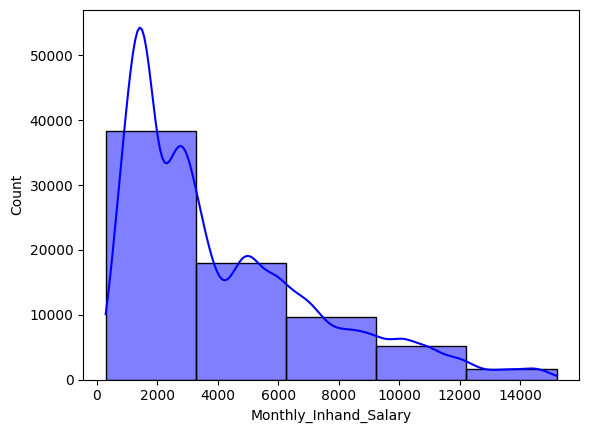

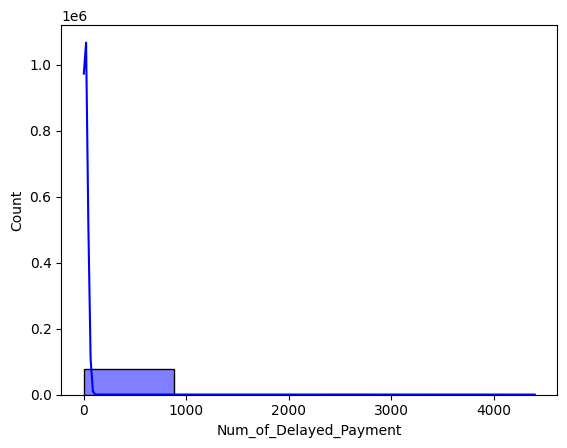

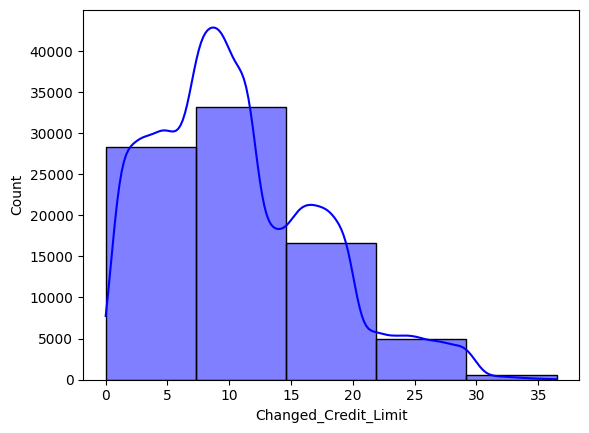

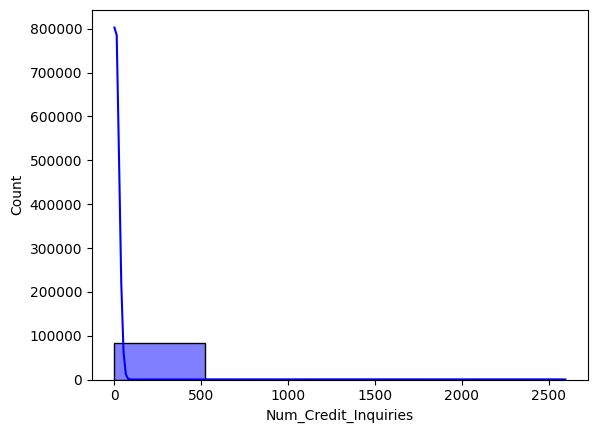

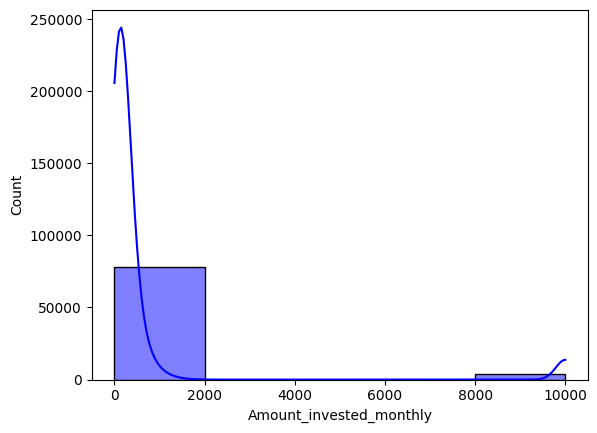

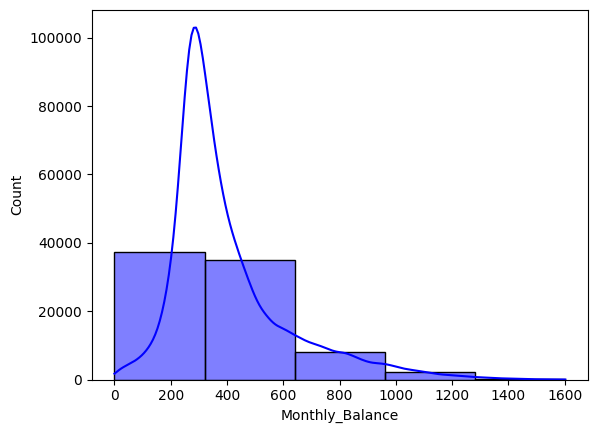

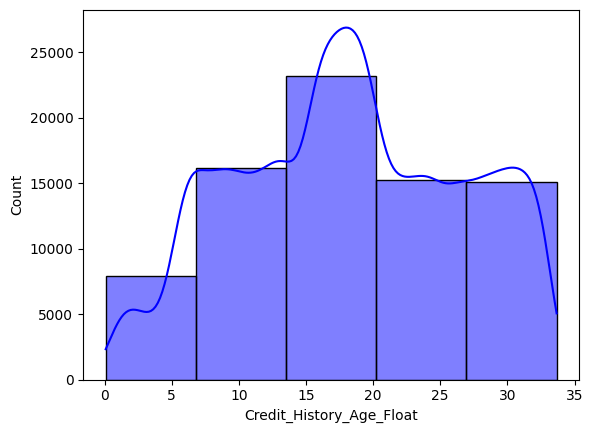

In [44]:
for col in missing_columns:
    sns.histplot(
        data = df_train,
        x = col,
        kde = True,
        color = 'blue',
        bins=5
    )
    plt.show()

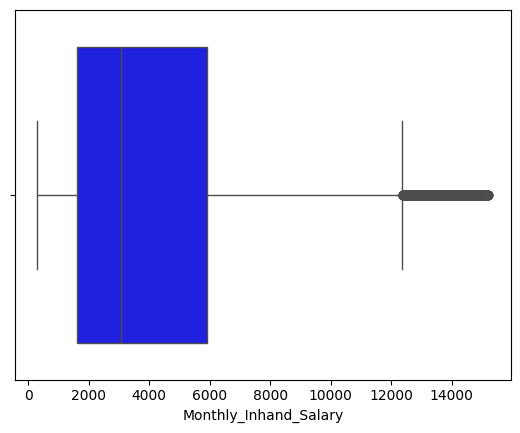

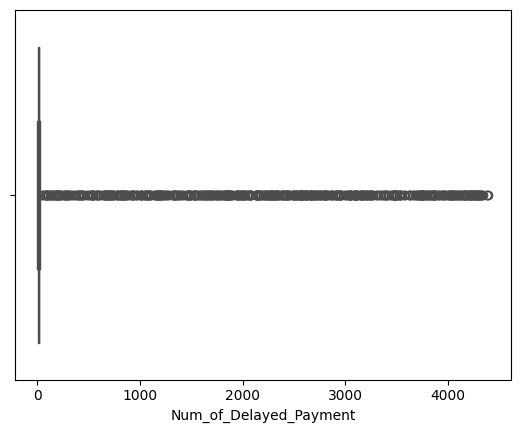

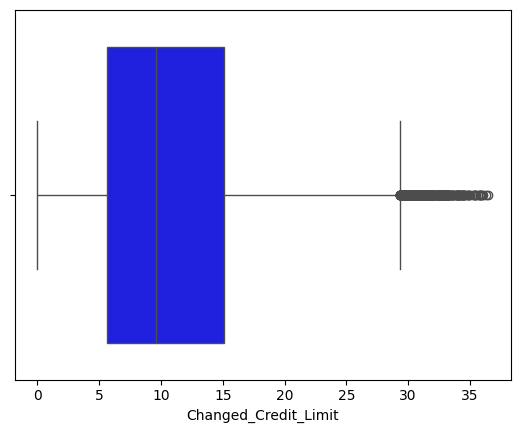

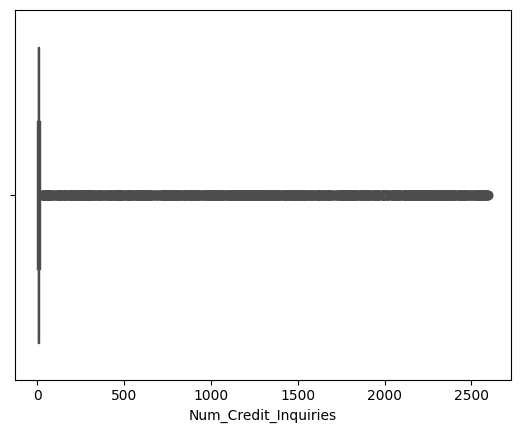

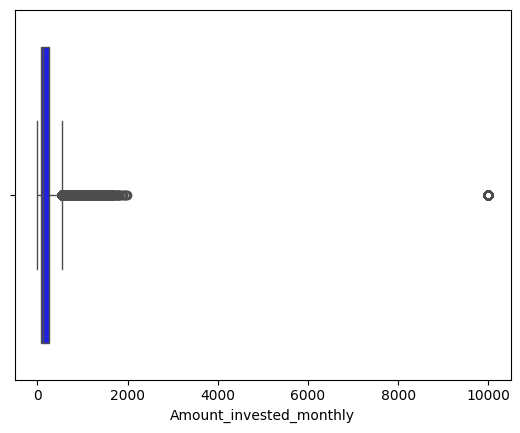

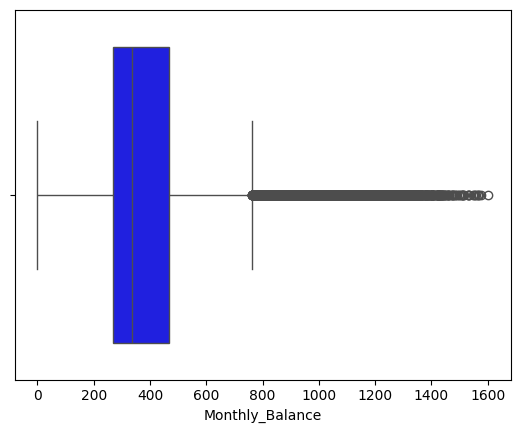

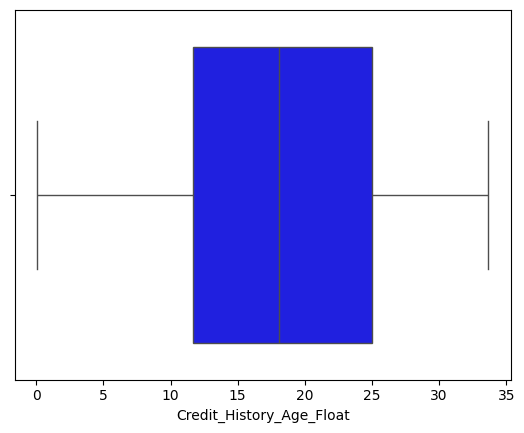

In [45]:
for col in missing_columns:
    sns.boxplot(
        data = df_train,
        x = col,
        color = 'blue'
    )
    plt.show()

For Amount_invested_monthly, there is a gap between investing less than 1000 (more than 88k) and investing more than 9000 (more than 4k).

For Num_of_Delayed_Payment and Num_Credit_Inquiries, most values are concentrated around 0.

There are extreme outliers for Monthly_balance, we need to remove them

In [46]:
df_train['Monthly_Balance'].describe()

count    82965.000000
mean       400.485587
std        212.278429
min          0.007760
25%        269.533995
50%        335.429828
75%        467.313006
max       1602.040519
Name: Monthly_Balance, dtype: float64

In [47]:
df_train.loc[df_train['Monthly_Balance'] < 0, 'Monthly_Balance'].count()

0

In [48]:
df_train = df_train.loc[df_train['Monthly_Balance']>=0]

<Axes: xlabel='Monthly_Balance', ylabel='Count'>

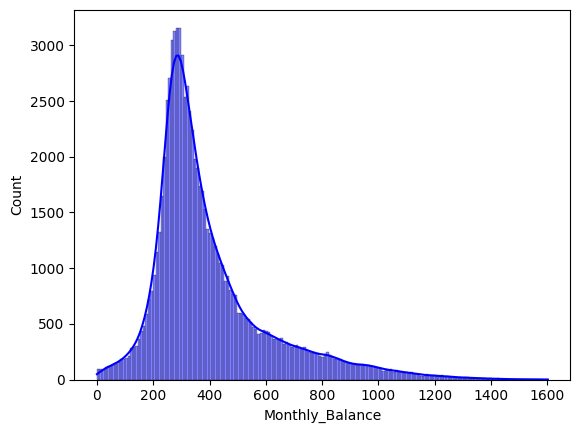

In [49]:
sns.histplot(
    data = df_train,
    x = 'Monthly_Balance',
    kde = True,
    color = 'blue'
)

It seems all the missing columns are heavily right-skewed, we will use median fill, save the mdeians and then use them on the test set.

In [50]:
medians = {}
def median_fill(df, missing_columns):
    for col in missing_columns:
        median = df[col].median()
        df[col].fillna(median, inplace=True)
        medians[col] = median

In [51]:
median_fill(df_train, missing_columns)

/var/folders/rt/q1nqm7vd4j175p7gyf5tqnhh0000gn/T/ipykernel_2509/387488317.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(median, inplace=True)
/var/folders/rt/q1nqm7vd4j175p7gyf5tqnhh0000gn/T/ipykernel_2509/387488317.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a 

In [52]:
for col in missing_columns:
    df_test[col].fillna(medians[col], inplace=True)

/var/folders/rt/q1nqm7vd4j175p7gyf5tqnhh0000gn/T/ipykernel_2509/1584099250.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_test[col].fillna(medians[col], inplace=True)


In [53]:
df_train.isna().sum()

Age                         0
Occupation                  0
Annual_Income               0
Monthly_Inhand_Salary       0
Num_Bank_Accounts           0
Num_Credit_Card             0
Interest_Rate               0
Num_of_Loan                 0
Delay_from_due_date         0
Num_of_Delayed_Payment      0
Changed_Credit_Limit        0
Num_Credit_Inquiries        0
Credit_Mix                  0
Outstanding_Debt            0
Credit_Utilization_Ratio    0
Payment_of_Min_Amount       0
Total_EMI_per_month         0
Amount_invested_monthly     0
Payment_Behaviour           0
Monthly_Balance             0
Credit_Score                0
Credit_History_Age_Float    0
Student Loan                0
Debt Consolidation Loan     0
Mortgage Loan               0
Payday Loan                 0
Credit-Builder Loan         0
Home Equity Loan            0
Personal Loan               0
Not Specified               0
Auto Loan                   0
dtype: int64

In [54]:
df_test.isna().sum()

Age                         0
Occupation                  0
Annual_Income               0
Monthly_Inhand_Salary       0
Num_Bank_Accounts           0
Num_Credit_Card             0
Interest_Rate               0
Num_of_Loan                 0
Delay_from_due_date         0
Num_of_Delayed_Payment      0
Changed_Credit_Limit        0
Num_Credit_Inquiries        0
Credit_Mix                  0
Outstanding_Debt            0
Credit_Utilization_Ratio    0
Payment_of_Min_Amount       0
Total_EMI_per_month         0
Amount_invested_monthly     0
Payment_Behaviour           0
Monthly_Balance             0
Credit_History_Age_Float    0
Student Loan                0
Debt Consolidation Loan     0
Mortgage Loan               0
Payday Loan                 0
Credit-Builder Loan         0
Home Equity Loan            0
Personal Loan               0
Not Specified               0
Auto Loan                   0
dtype: int64

Now, all missing columns are filled

In [55]:
df_train['Credit_Score']

0            Good
3            Good
4            Good
5            Good
6            Good
           ...   
98298    Standard
98299    Standard
98301    Standard
98302    Standard
98303    Standard
Name: Credit_Score, Length: 82965, dtype: object

<a id="eda" ></a>
# Data analysis

<a id="univariate" ></a>
# Univariate analysis

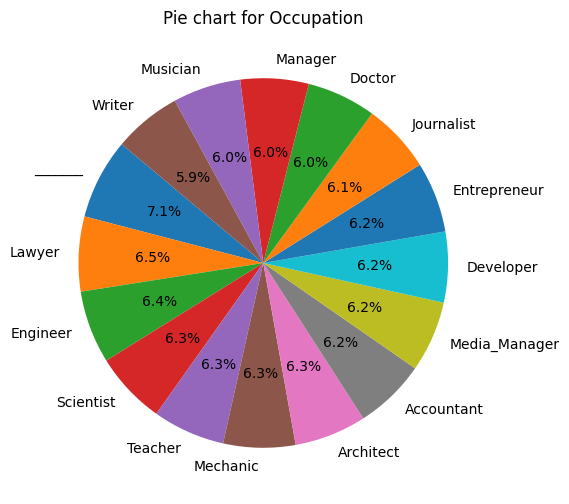

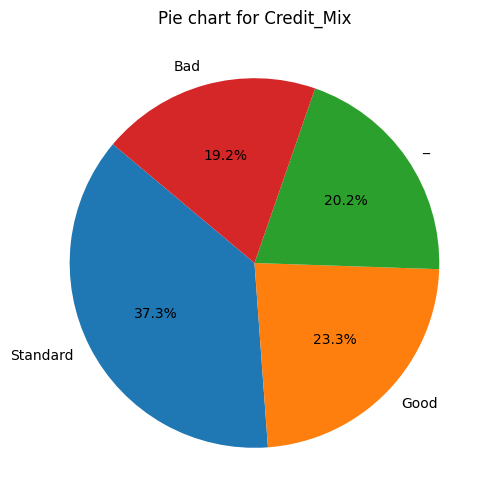

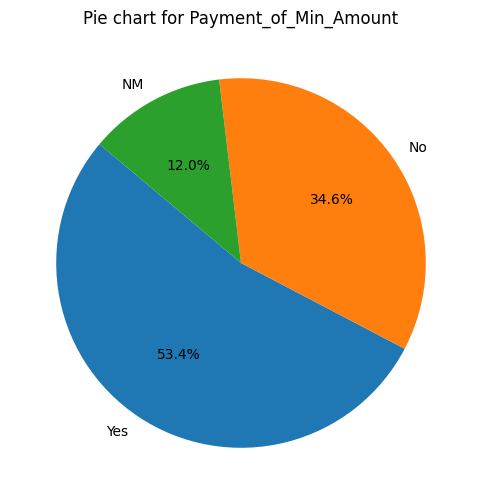

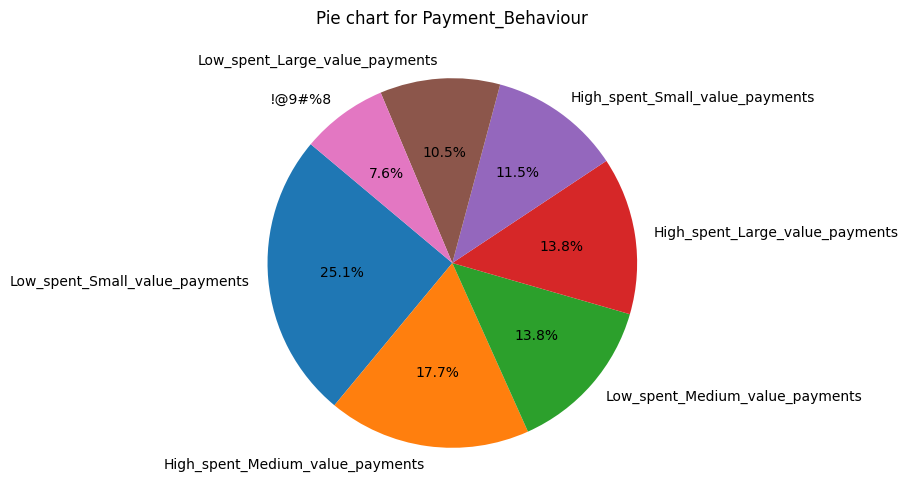

In [56]:
for col in cat_features:
    counts = df_train[col].value_counts()
    plt.figure(figsize=(6,6))
    plt.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=140)
    plt.title(f'Pie chart for {col}')
    plt.show()

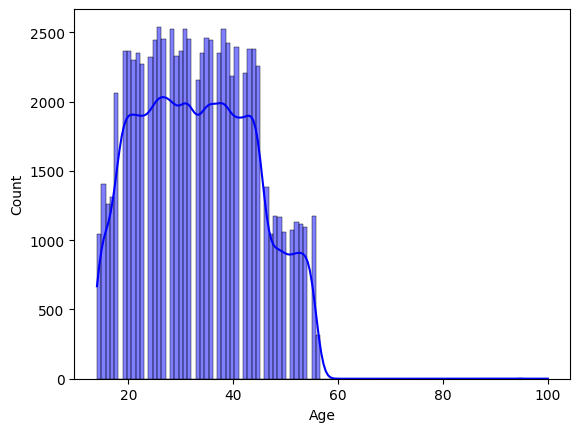

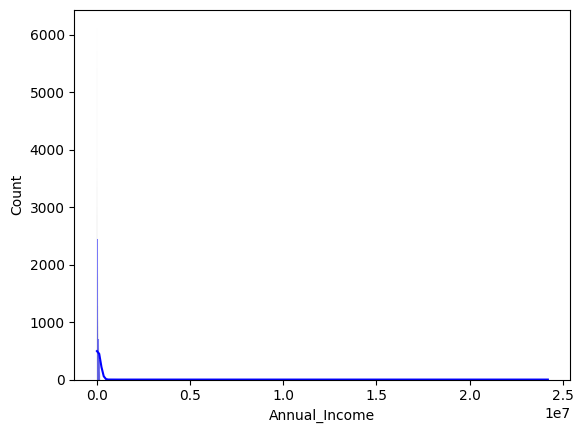

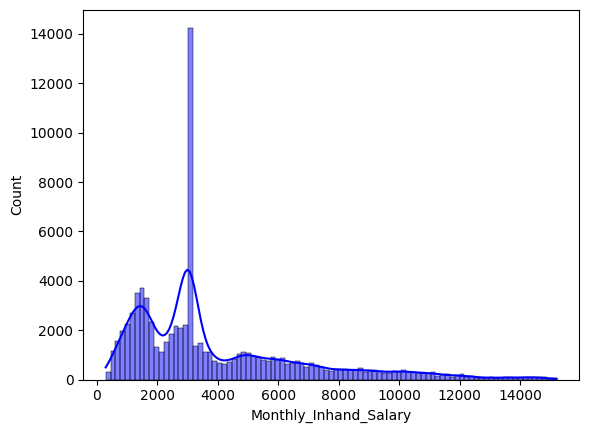

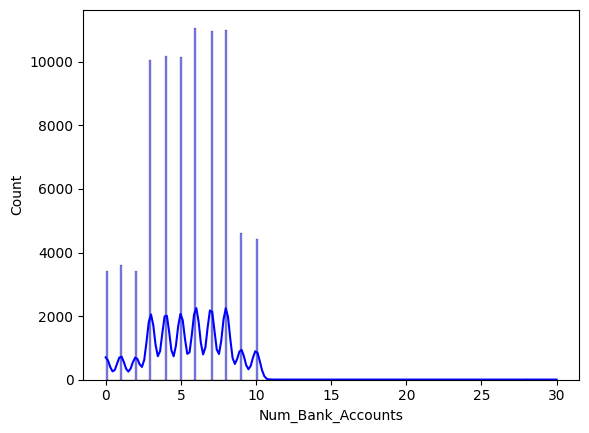

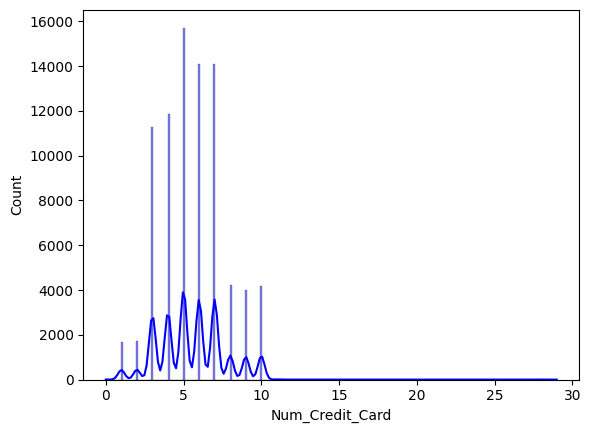

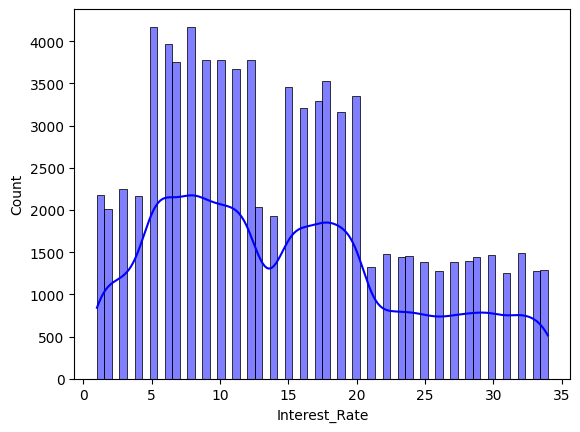

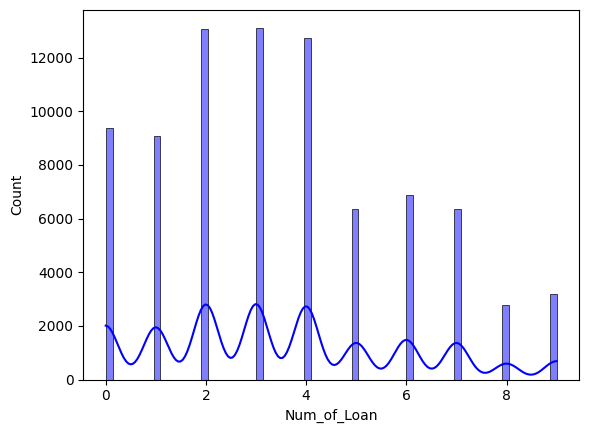

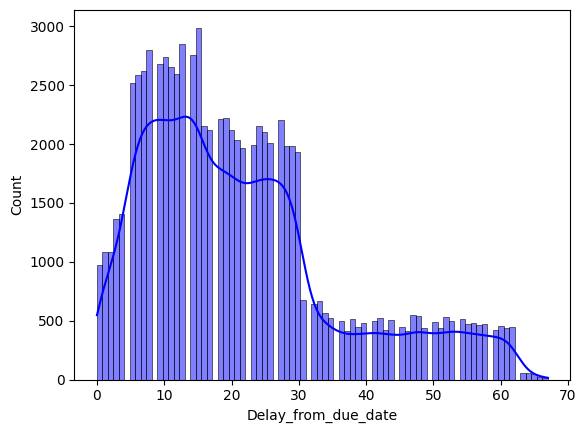

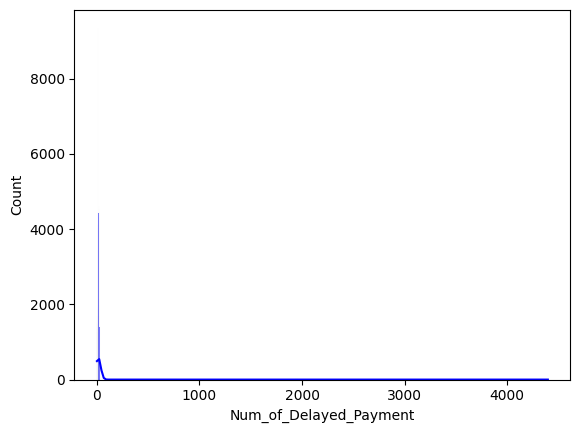

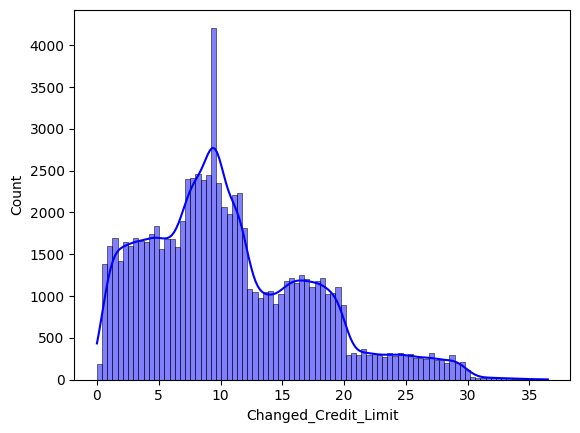

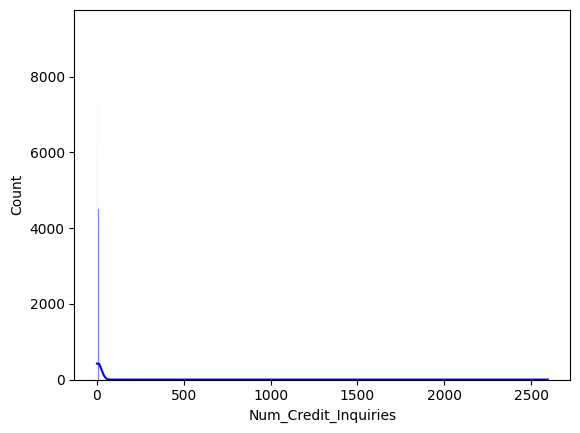

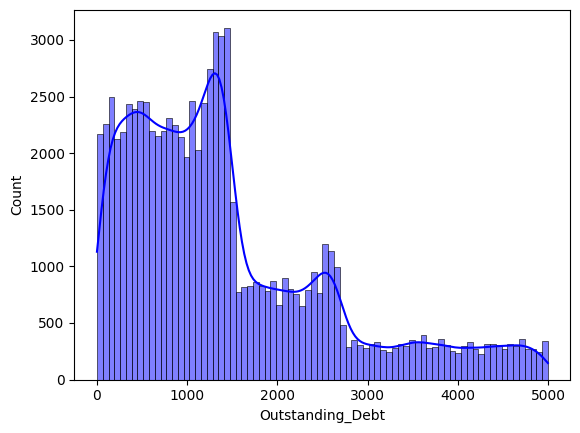

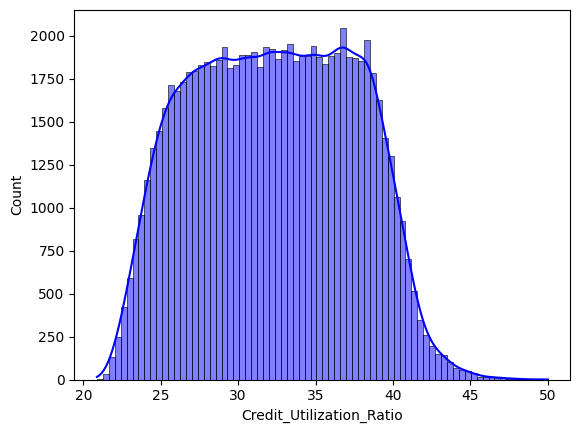

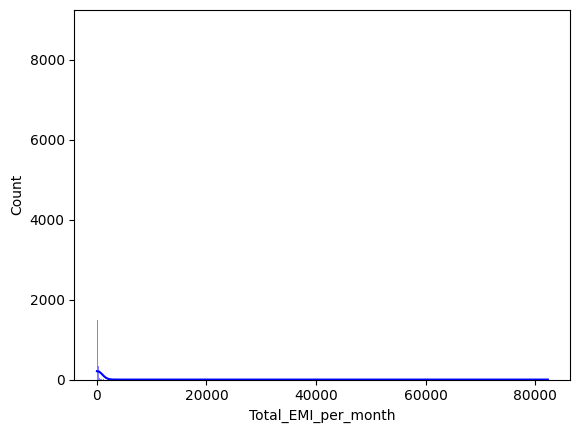

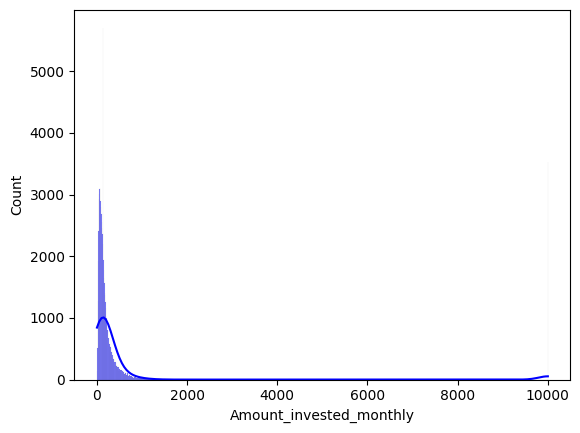

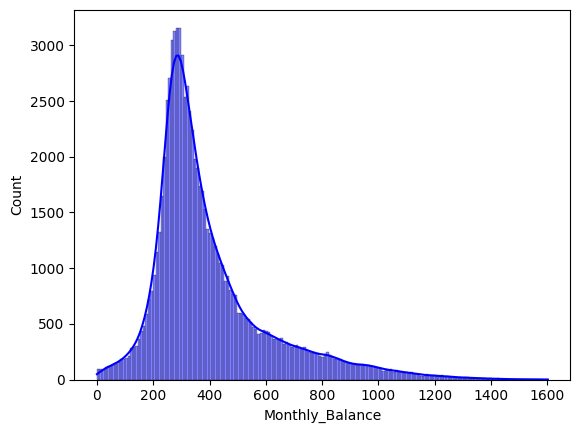

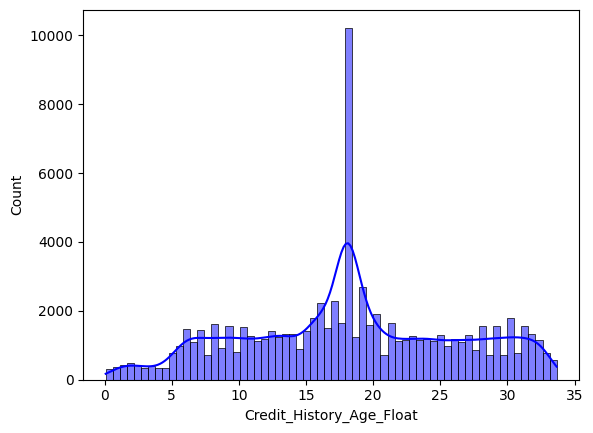

In [57]:
for col in num_features:
    sns.histplot(
        data = df_train,
        x = col,
        kde = True,
        color = 'blue'
    )
    plt.show()

<a id="bivariate" ></a>
# Bivariate Analysis

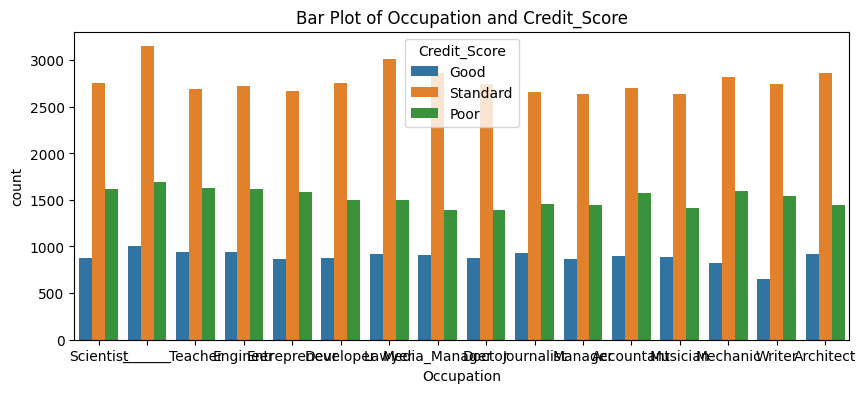

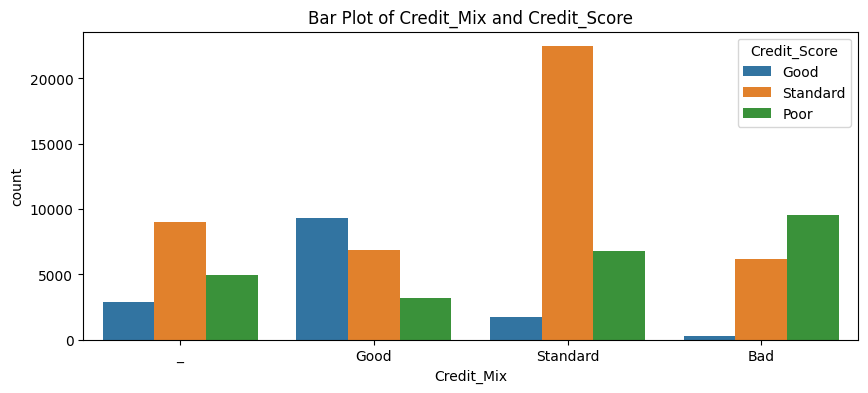

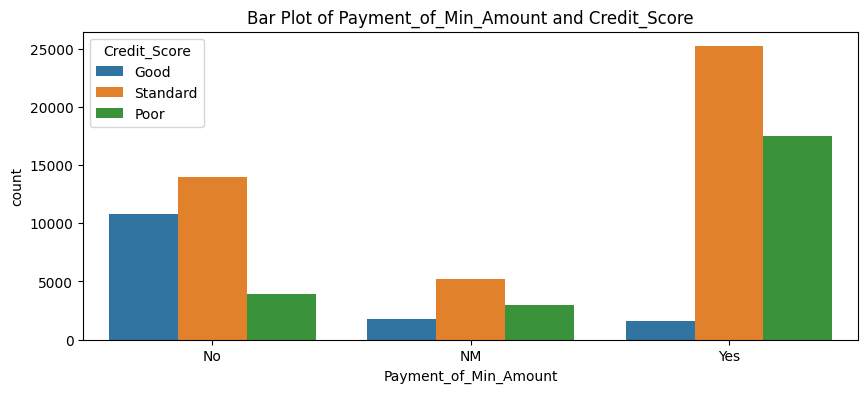

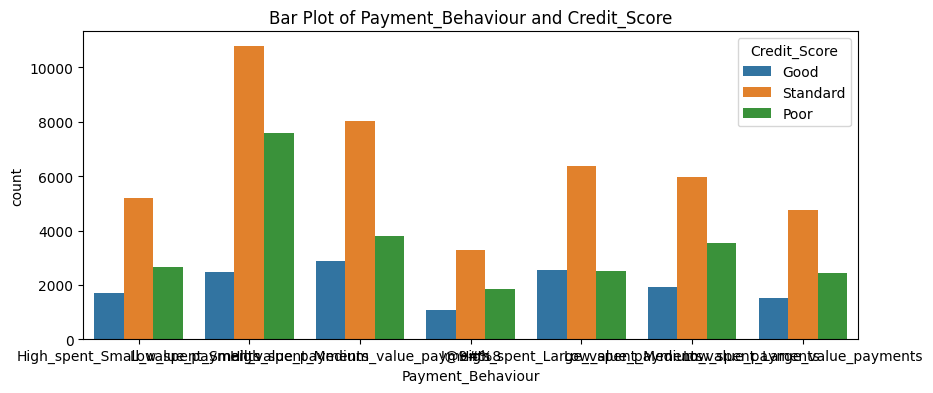

In [58]:
for feature in cat_features:
    plt.figure(figsize=(10, 4))
    sns.countplot(x=feature, hue='Credit_Score', data=df_train)
    plt.title(f'Bar Plot of {feature} and Credit_Score')
    plt.show()

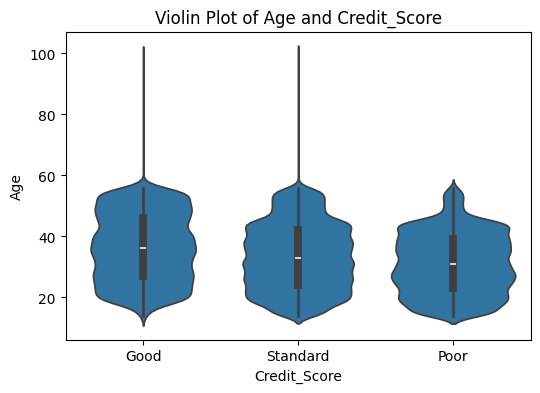

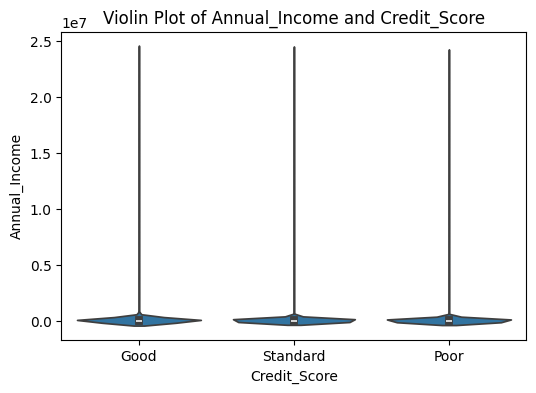

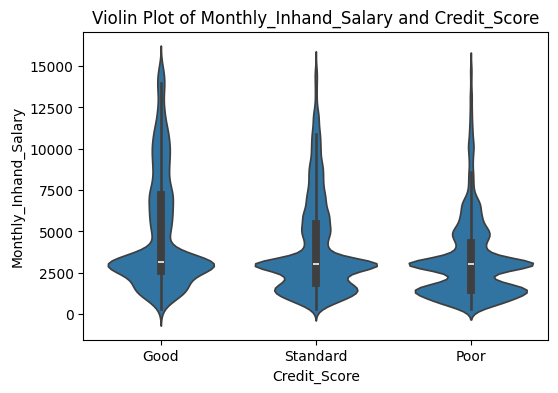

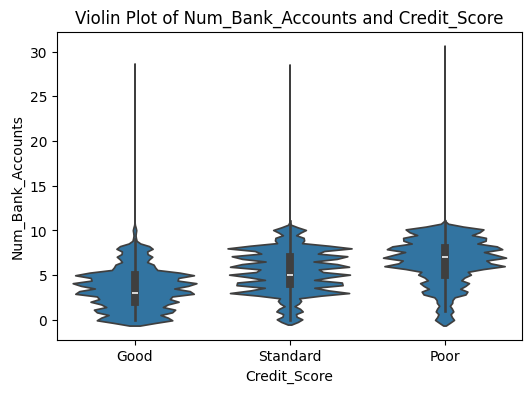

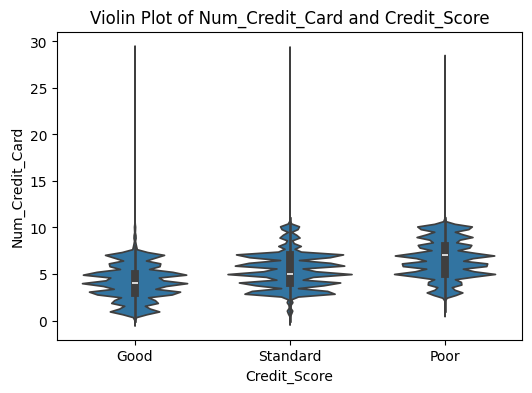

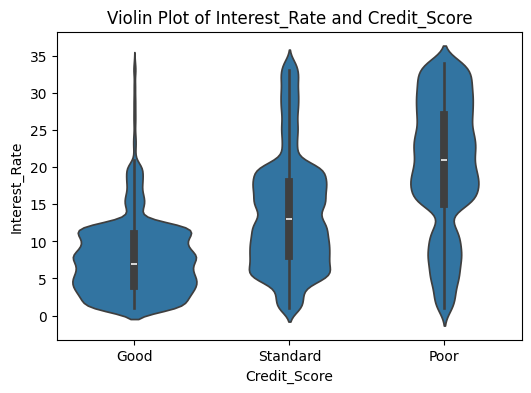

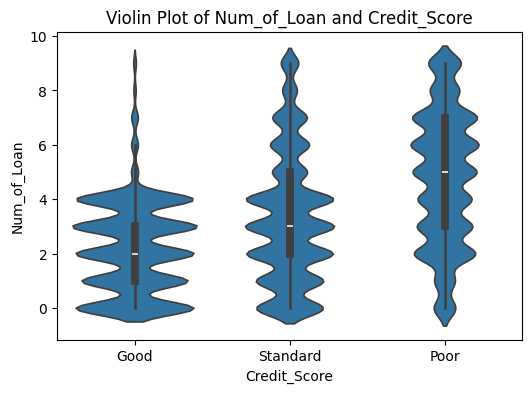

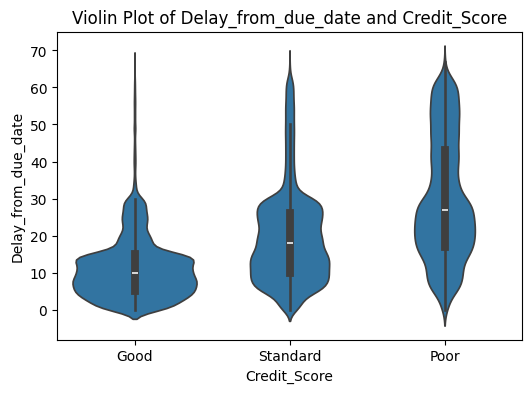

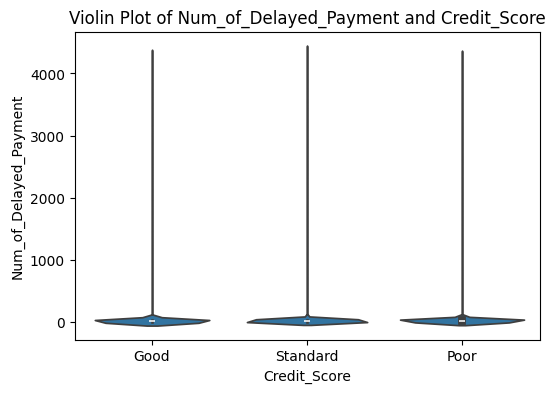

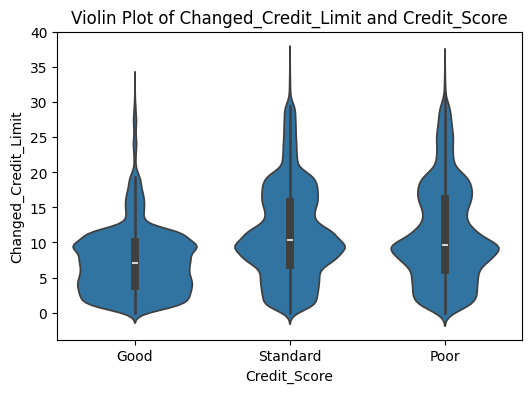

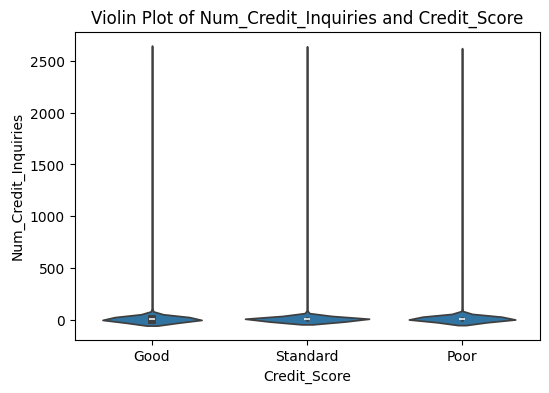

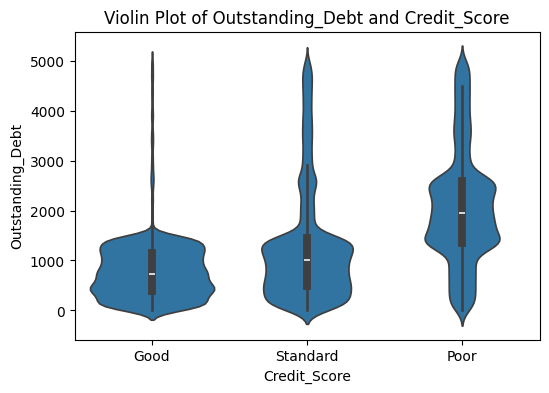

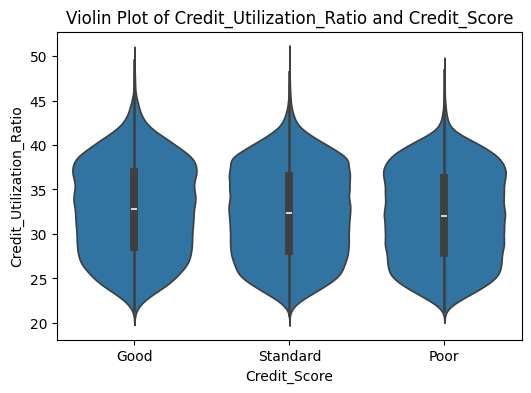

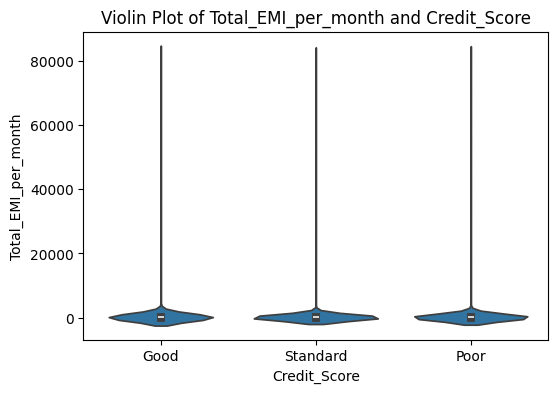

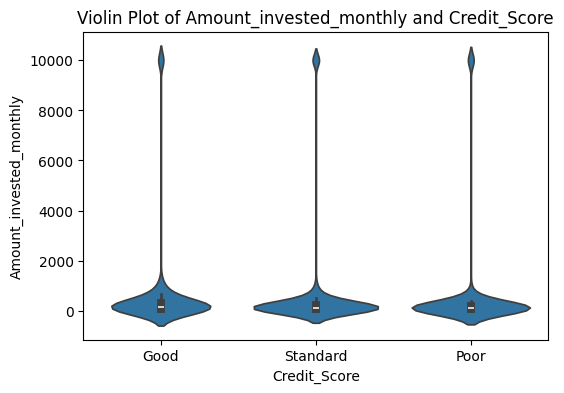

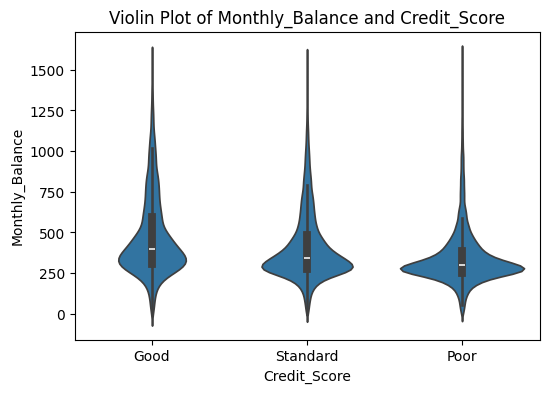

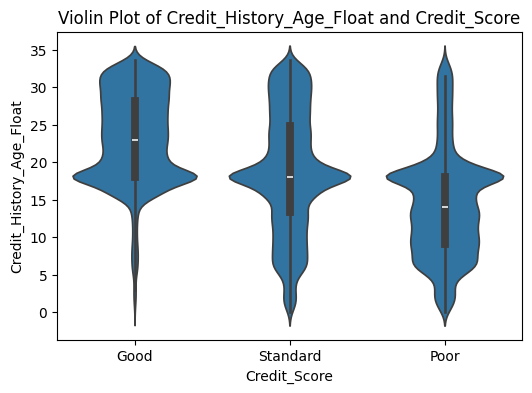

In [59]:
for feature in num_features:
    plt.figure(figsize=(6, 4))
    sns.violinplot(y=feature,x='Credit_Score', data = df_train)
    plt.title(f'Violin Plot of {feature} and Credit_Score')
    plt.show()

A few remarks:

- There are not many Good Credit_Score with high Changed_Credit_Limit and high Outstanding_Debt, Interest_Rate and Delay_from_due_day.

- Most people with Good Credit_Score have Credit_History_Age > 15.

<a id="encode-and-scale" ></a>
# Encoding and scaling

In [60]:
from sklearn.preprocessing import LabelEncoder

In [61]:
def label_encoding(df, cat_features):
    # Copy the dataframe to avoid changes to the original
    df_processed = df.copy()
    encoders={}
    
    # Handle categorical features
    for feature in cat_features:
        # Fill missing values with a specific label -1
        df_processed[feature] = df_processed[feature].fillna(-1)
        
        # Define valid_index
        valid_index = df_processed[feature] != -1
        encoder = LabelEncoder()
        # Label encoding with valid_index
        df_processed.loc[valid_index, feature] = encoder.fit_transform(df_processed.loc[valid_index, feature])
        
        # Ensure the dtype is integer for the manual label
        df_processed[feature] = df_processed[feature].astype(int)
        encoders[feature] = encoder  
        
    return df_processed, encoders

In [62]:
df_train, encoders = label_encoding(df_train, cat_features)

In [63]:
for col in cat_features:
    df_test[col] = encoders[col].transform(df_test[col])

In [64]:
df_test.head()

,Age,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,...,Credit_History_Age_Float,Student Loan,Debt Consolidation Loan,Mortgage Loan,Payday Loan,Credit-Builder Loan,Home Equity Loan,Personal Loan,Not Specified,Auto Loan
0,23.0,12,19114.12,1824.843333,3,4,3,4.0,3,7.0,...,22.750000,0,0,0,0,1,1,1,0,1
1,24.0,12,19114.12,1824.843333,3,4,3,4.0,3,9.0,...,22.083333,0,0,0,0,1,1,1,0,1
2,24.0,12,19114.12,1824.843333,3,4,3,4.0,-1,4.0,...,18.083333,0,0,0,0,1,1,1,0,1
3,24.0,12,19114.12,3038.946667,3,4,3,4.0,4,5.0,...,23.000000,0,0,0,0,1,1,1,0,1
4,28.0,15,34847.84,3037.986667,2,4,6,1.0,3,1.0,...,27.250000,0,0,0,0,1,0,0,0,0


In [65]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_train[num_features] = scaler.fit_transform(df_train[num_features])

df_test[num_features] = scaler.transform(df_test[num_features])

In [66]:
df_test.head()

,Age,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,...,Credit_History_Age_Float,Student Loan,Debt Consolidation Loan,Mortgage Loan,Payday Loan,Credit-Builder Loan,Home Equity Loan,Personal Loan,Not Specified,Auto Loan
0,-0.950576,12,-0.109143,-0.729627,-0.937621,-0.746427,-1.335031,0.185427,-1.237394,-0.105061,...,0.576438,0,0,0,0,1,1,1,0,1
1,-0.857874,12,-0.109143,-0.729627,-0.937621,-0.746427,-1.335031,0.185427,-1.237394,-0.095849,...,0.492344,0,0,0,0,1,1,1,0,1
2,-0.857874,12,-0.109143,-0.729627,-0.937621,-0.746427,-1.335031,0.185427,-1.507740,-0.118879,...,-0.012221,0,0,0,0,1,1,1,0,1
3,-0.857874,12,-0.109143,-0.314982,-0.937621,-0.746427,-1.335031,0.185427,-1.169808,-0.114273,...,0.607974,0,0,0,0,1,1,1,0,1
4,-0.487068,15,-0.098143,-0.315310,-1.325118,-0.746427,-0.991846,-1.042079,-1.237394,-0.132696,...,1.144074,0,0,0,0,1,0,0,0,0


<a id="utilities" ></a>
# Utilities

In [67]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

In [68]:
def model_evaluation(y_true, y_pred):
    # Calculate metrics
    f1 = f1_score(y_true, y_pred, average='weighted')
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    accuracy = accuracy_score(y_true, y_pred)
    
    # Print or return the scores
    print(f'F1 Score: {f1:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'Accuracy: {accuracy:.4f}')

def cross_validation(estimator, X, y, score = 'accuracy', n = 5):
    validate = cross_val_score(estimator, X, y, scoring = score, cv = n)
    print("Accuracy mean score: ", validate.mean())
    
# Hypertunning
def hyper_tune(estimator, X, y, param_grid, score = 'accuracy', n = 5):
    grid_search = GridSearchCV(
        estimator=estimator,
        param_grid=param_grid,
        scoring=score,
        cv=n
    )
    grid_search.fit(X, y)
    best_score = grid_search.best_score_
    print("Best accuracy score: ", best_score)
    return grid_search.best_estimator_

<a id="train-and-validate" ></a>
# Train and validate with LGBM

In [69]:
encoder_credit = LabelEncoder()
df_train['Credit_Score'] = encoder_credit.fit_transform(df_train['Credit_Score'])

In [70]:
X = df_train.drop(columns = ['Credit_Score'], axis=1).values
y = df_train['Credit_Score']
print(X.shape)
print(y.shape)

(82965, 30)
(82965,)


In [71]:
from sklearn.model_selection import train_test_split

In [72]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, shuffle = True, random_state = 42)

In [73]:
from lightgbm import LGBMClassifier

In [74]:
gbm = LGBMClassifier(num_leaves = 31, verbose = -1)
cross_validation(gbm, X_train, y_train)

Accuracy mean score:  0.7327638306849662


In [75]:
gbm.fit(X_train, y_train)

LGBMClassifier(verbose=-1)

In [76]:
y_val_pred = gbm.predict(X_val)
model_evaluation(y_val, y_val_pred)

F1 Score: 0.7296
Precision: 0.7312
Recall: 0.7292
Accuracy: 0.7292


<a id="hypertune" ></a>
# Hypertuning

In [77]:
# This takes some time to run
param_grid = {
    'num_leaves': [31, 63, 90],
    'learning_rate': [0.02, 0.05, 0.15],
    'n_estimators': [100, 120, 150],
    'verbose': [-1]
}
best_gbm = hyper_tune(gbm, X_val, y_val, param_grid)

Best accuracy score:  0.7215692214315408


In [78]:
best_gbm.fit(X_train, y_train)

LGBMClassifier(learning_rate=0.15, n_estimators=150, num_leaves=90, verbose=-1)

In [79]:
y_val_pred = best_gbm.predict(X_val)
model_evaluation(y_val, y_val_pred)

F1 Score: 0.7762
Precision: 0.7761
Recall: 0.7763
Accuracy: 0.7763


In [80]:
# We are now ready to predict y_test:
# X_test = df_test.values
# y_test_pred = best_gbm.predict(y_test)
# model_evaluation(y_test, y_test_pred)

<a id="important-features" ></a>
# Important features

In [81]:
lst = df_train.drop(columns=['Credit_Score']).columns.to_list()

def get_important_features(best_clf, top_n):
    
    # Get feature importances
    importance = best_clf.feature_importances_

    # Get indices of sorted importances
    sorted_indices = np.argsort(importance)[::-1]
    
    top_n_features = [lst[index] for index in sorted_indices[:top_n]]
    print(f"Top {top_n} important features: ", top_n_features)

    plt.figure(figsize=(10, 6))
    plt.barh(range(len(sorted_indices)), importance[sorted_indices], align='center')
    plt.yticks(range(len(sorted_indices)), importance)
    plt.xlabel("Feature Importance")
    plt.title("Feature Importances in Classifier Model")
    plt.gca().invert_yaxis()  # Invert y-axis to have the most important at the top
    plt.show()

Top 5 important features:  ['Outstanding_Debt', 'Changed_Credit_Limit', 'Credit_History_Age_Float', 'Total_EMI_per_month', 'Age']


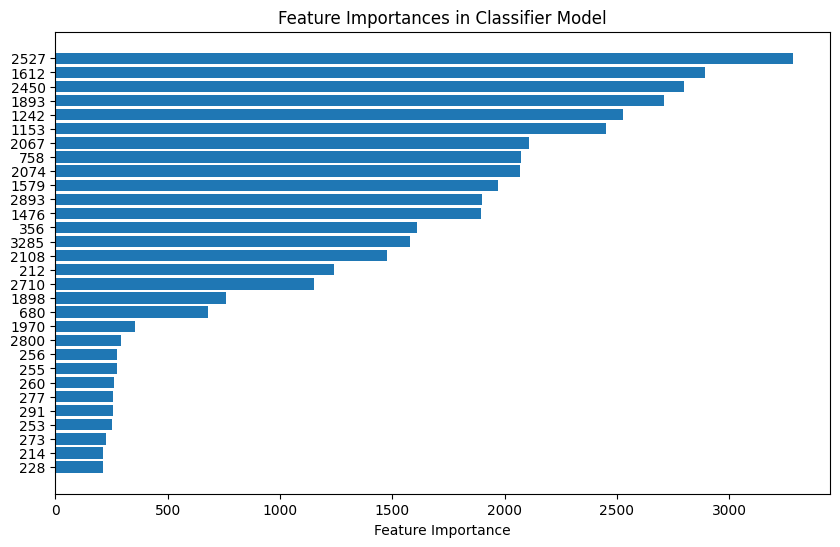

In [82]:
# Top 5 important features
get_important_features(best_gbm, top_n=5)

<a id="conclusion" ></a>
# Conclusion

LGBM is a good model for this problem with consitent weighted scores and accuracy scores (77%). Top 5 important features are: ['Outstanding_Debt', 'Changed_Credit_Limit', 'Credit_History_Age_Float', 'Total_EMI_per_month', 'Age'].